<a href="https://colab.research.google.com/github/mahmoudhaney/TrafficSignRecognition/blob/main/GTSRB_With_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Link Kaggle Dataset**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrarray22","key":"e5f2190057d9831ec5c135e120b111c8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
# Unzip dataset
! unzip gtsrb-german-traffic-sign.zip

# **2. Import Dependencies**



In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **3. Preparing & Preprocessing Dataset**

In [ ]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

In [ ]:
# Get the images and their labels
for i in range(classes):
  # Get images in each sub folder in train folder  
  path = os.path.join(cur_path,'train',str(i))
  images = os.listdir(path)

  # Resize every image & convert it into array
  for a in images:
    image = Image.open(path + '/'+ a)
    image = image.resize((30,30))
    image = np.array(image)
    data.append(image)
    labels.append(i)

In [ ]:
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


# **4. Splitting Dataset**

In [ ]:
# Training data => 80%
# Testing  data => 20%
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
# Converting the labels into one encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Link Lables to Images

In [ ]:
dataset_dir = './'

folderMap = {
    0: '20 km/h', 1: '30 km/h', 2: '50 km/h', 3: '60 km/h', 4: '70 km/h', 5: '80 km/h', 6:'80 km/h end', 7: '100 km/h', 8: '120 km/h', 
    9: 'No overtaking', 10: 'No overtaking for tracks', 11: 'Crossroad with secondary way', 12: 'Main road', 13: 'Give way', 14: 'Stop', 
    15: 'Road up', 16: 'Road up for track', 17: 'Brock', 18: 'Other dangerous', 19: 'Turn left', 20: 'Turn right', 21: 'Winding road', 
    22: 'Hollow road', 23: 'Slippery road', 24: 'Narrowing road', 25: 'Roadwork', 26: 'Traffic light', 27: 'Pedestrian', 28: 'Children', 
    29: 'Bike', 30: 'Snow', 31: 'Deer', 32: 'End of the limits', 33: 'Only right', 34: 'Only left', 35: 'Only straight', 36: 'Only straight and right', 
    37: 'Only straight and left', 38: 'Take right', 39: 'Take left', 40: 'Circle crossroad', 41: 'End of overtaking limit', 42: 'End of overtaking limit for track'
}

In [ ]:
Meta = os.path.join(dataset_dir, 'Meta')
Train = os.path.join(dataset_dir, 'Train')

In [ ]:
num_classes = len(os.listdir(Train))
num_classes

43

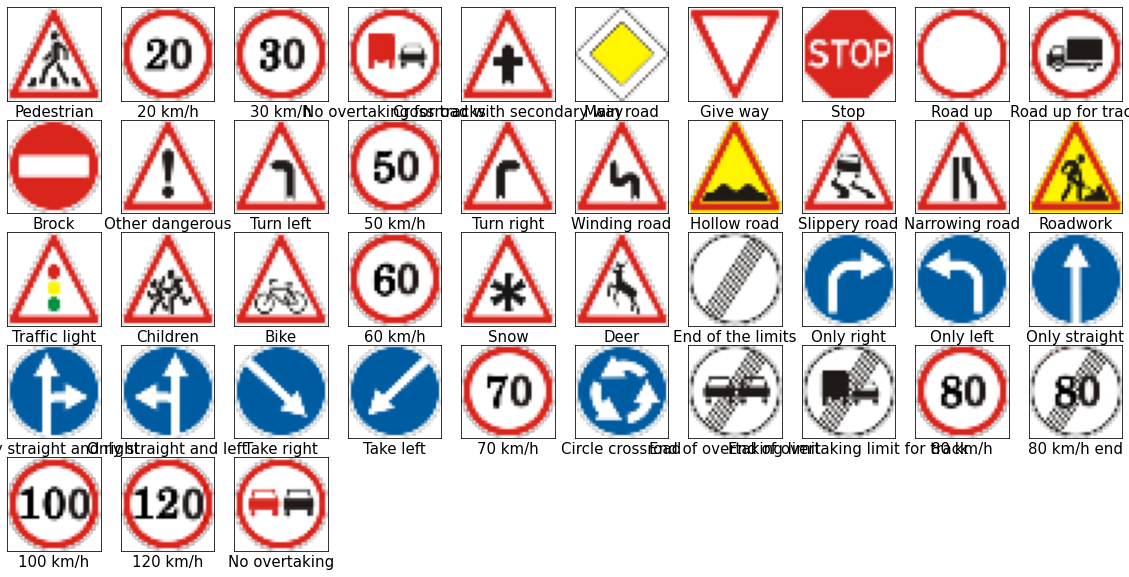

In [ ]:
df = pd.read_csv(os.path.join(dataset_dir, 'Meta.csv'))
df = df.sort_values(by=['ClassId'])

meta_images = []
meta_labels = []

for i in range(df.shape[0]):
    label = df.ClassId[i]
    image_path_meta = df.Path[i]
    image_path = os.path.join(dataset_dir, image_path_meta)
    image = plt.imread(image_path)
    image = cv2.resize(image, (32, 32))
    meta_images.append(image)
    meta_labels.append(folderMap[int(label)])

fig = plt.figure(figsize=(20, 10))
for i in range(len(meta_images)):
    ax = fig.add_subplot(5, 10, i+1)
    plt.axis()
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel(xlabel = meta_labels[i], fontsize=15)
    ax.imshow(meta_images[i])

# **5. Building the Model**

In [ ]:
# Resizing the images to 30 x 30 x 3
IMAGE_HEIGHT = 30
IMAGE_WIDTH = 30
channels = 3

In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,channels)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

### Model Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 256)        

### Some Ploting

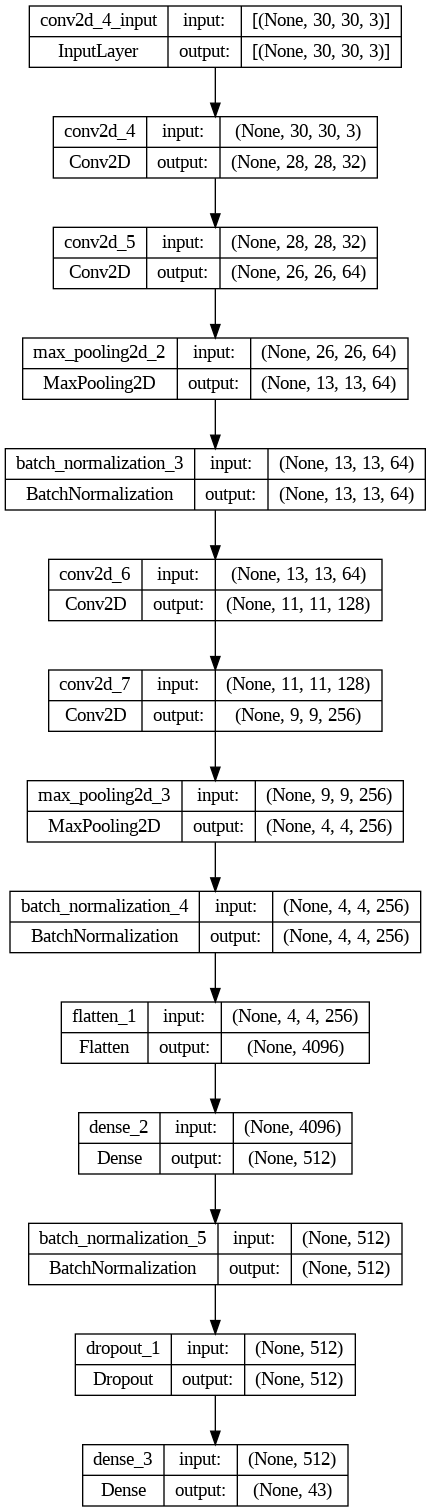

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

### Training The Model

In [ ]:
# Set Learining Rate to --> 0.001
lr = 0.001
epochs = 30

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Make some Modifications on Images
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Train The Model
history= model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/30
981/981 [==============================] - 23s 23ms/step - loss: 0.1172 - accuracy: 0.9643 - val_loss: 0.0308 - val_accuracy: 0.9923
Epoch 2/30
981/981 [==============================] - 22s 22ms/step - loss: 0.0746 - accuracy: 0.9781 - val_loss: 0.0203 - val_accuracy: 0.9940
Epoch 3/30
981/981 [==============================] - 22s 22ms/step - loss: 0.0573 - accuracy: 0.9829 - val_loss: 0.0185 - val_accuracy: 0.9940
Epoch 4/30
981/981 [==============================] - 22s 22ms/step - loss: 0.0520 - accuracy: 0.9846 - val_loss: 0.0098 - val_accuracy: 0.9969
Epoch 5/30
981/981 [==============================] - 21s 22ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0116 - val_accuracy: 0.9971
Epoch 6/30
981/981 [==============================] - 22s 22ms/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.0081 - val_accuracy: 0.9973
Epoch 7/30
981/981 [==============================] - 22s 22ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0080 - val_accuracy:

In [ ]:
# Save The Model
model.save("NN_Model.h5")

# **6. Model Evaluation**

### Model Accuracy

In [ ]:
# Import Accuracy Score
from sklearn.metrics import accuracy_score

# Testing data
y_test = pd.read_csv('Test.csv')
labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))

In [ ]:
X_test = np.array(data)
predict = model.predict(X_test) 
classes = np.argmax(predict, axis=1)

395/395 [==============================] - 1s 2ms/step


In [ ]:
print("Accuracy Score => ", accuracy_score(labels, classes)*100)

Accuracy Score =>  98.47980997624704


### Accuracy Curve

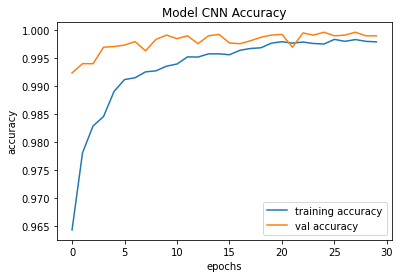

In [ ]:
# For Accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model CNN Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Loss Curve

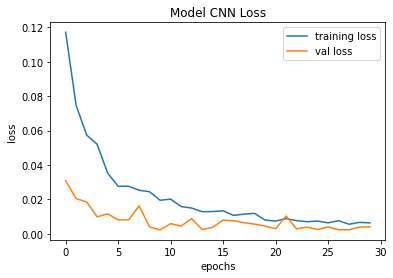

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model CNN Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Confusion Matrix

<Axes: >

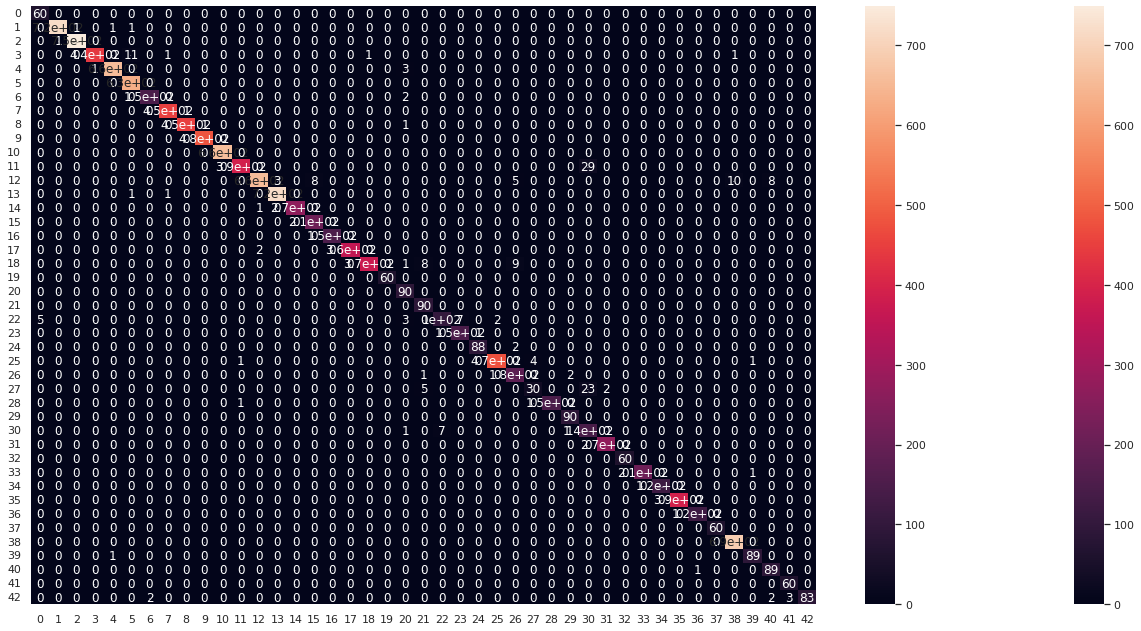

In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(labels, classes)
df_cm = pd.DataFrame(cm, range(43), range(43))
sn.set(font_scale=1.0) # for label size
plt.figure(figsize = (22,11))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 2}) # font size
sn.heatmap(df_cm, annot=True)

### Visual Keras

In [ ]:
!pip install visualkeras
import visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


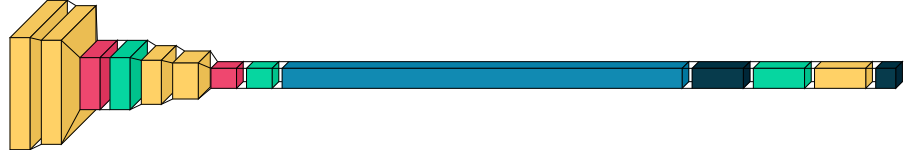

In [ ]:
visualkeras.layered_view(model)